# 1-1 结构化数据建模流程范例

### 一、准备数据

`titanic` 数据集的目标是根据乘客信息预测他们在 `Titanic` 号撞击冰山沉没后能否生存。

结构化数据一般会使用 `Pandas` 中的 `DataFrame` 进行预处理。

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

# 读取 csv 文件
df_train_raw = pd.read_csv("./data/titanic/train.csv")
df_test_raw = pd.read_csv("./data/titanic/test.csv")

# 输出训练数据集的前 10 行
df_train_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


字段说明：

* Survived:0 代表死亡，1 代表存活【 y 标签】
* Pclass:乘客所持票类，有三种值(1,2,3) 【转换成 onehot 编码】
* Name:乘客姓名 【舍去】
* Sex:乘客性别 【转换成 bool 特征】
* Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
* SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
* Parch:乘客父母/孩子的个数(整数值)【数值特征】
* Ticket:票号(字符串)【舍去】
* Fare:乘客所持票的价格(浮点数，0-500 不等) 【数值特征】
* Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
* Embarked:乘客登船港口:S、C、Q(有缺失)【转换成 onehot 编码，四维度 S,C,Q,nan】

利用 Pandas 的数据可视化功能我们可以简单地进行探索性数据分析 EDA（Exploratory Data Analysis）。

label 分布情况

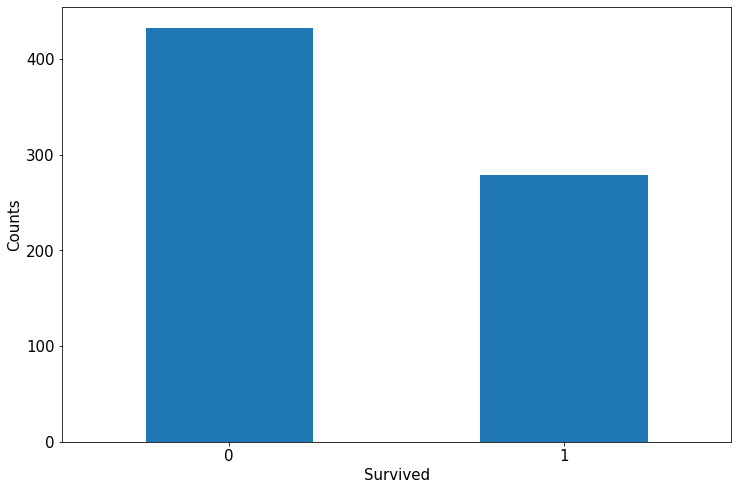

In [8]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'png'
ax = (
    df_train_raw["Survived"]
    .value_counts()
    .plot(kind="bar", figsize=(12, 8), fontsize=15, rot=0)
)
ax.set_ylabel("Counts", fontsize=15)
ax.set_xlabel("Survived", fontsize=15)
plt.show()

年龄分布情况

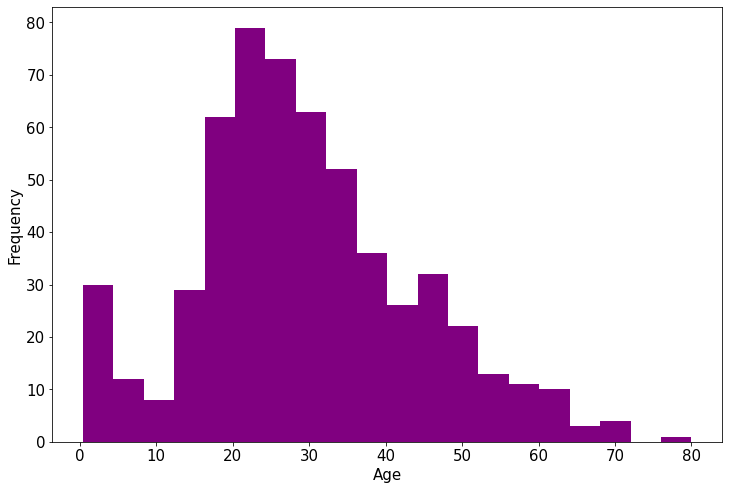

In [9]:
ax = df_train_raw["Age"].plot(
    kind="hist", bins=20, color="purple", figsize=(12, 8), fontsize=15
)
ax.set_ylabel("Frequency", fontsize=15)
ax.set_xlabel("Age", fontsize=15)
plt.show()

年龄和 label 的相关性

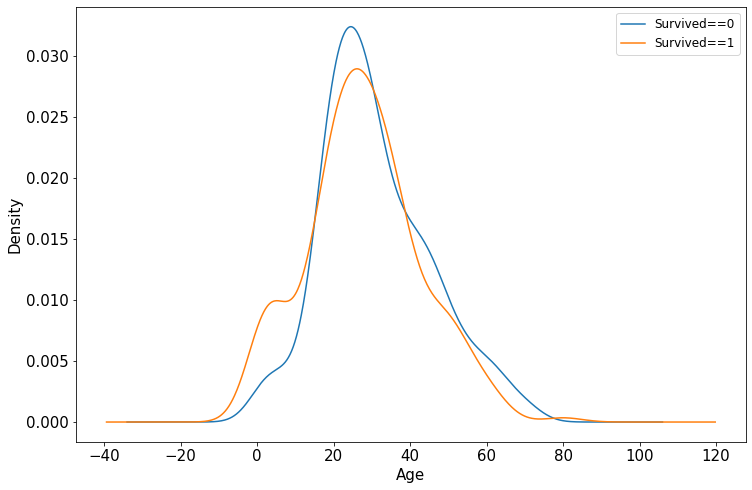

In [10]:
ax = df_train_raw.query("Survived == 0")["Age"].plot(
    kind="density", figsize=(12, 8), fontsize=15
)
df_train_raw.query("Survived == 1")["Age"].plot(
    kind="density", figsize=(12, 8), fontsize=15
)
ax.legend(["Survived==0", "Survived==1"], fontsize=12)
ax.set_ylabel("Density", fontsize=15)
ax.set_xlabel("Age", fontsize=15)
plt.show()

In [11]:
def preprocessing(df_data):
    df_result = pd.DataFrame()

    # Pclass
    df_p_class = pd.get_dummies(df_data["Pclass"])  # one-hot 编码
    df_p_class.columns = ["Pclass_" + str(x) for x in df_p_class.columns]  # 重命名 columns
    df_result = pd.concat([df_result, df_p_class], axis=1)  # 横向合并 DataFrame

    # Sex
    df_sex = pd.get_dummies(df_data["Sex"])
    df_result = pd.concat([df_result, df_sex], axis=1)

    # Age
    df_result["Age"] = df_data["Age"].fillna(0)  # 用 0 填充 NA/NaN 数据
    df_result["Age_null"] = pd.isna(df_data["Age"]).astype("int32")

    # SibSp, Parch, Fare
    df_result["SibSp"] = df_data["SibSp"]
    df_result["Parch"] = df_data["Parch"]
    df_result["Fare"] = df_data["Fare"]

    # Cabin
    df_result["Cabin_null"] = pd.isna(df_data["Cabin"]).astype(
        "int32"
    )  # 判断是否有 NA/NaN，并转换为 int32

    # Embarked
    df_embarked = pd.get_dummies(df_data["Embarked"], dummy_na=True)
    df_embarked.columns = ["Embarked_" + str(x) for x in df_embarked.columns]
    df_result = pd.concat([df_result, df_embarked], axis=1)

    return df_result


x_train = preprocessing(df_train_raw)
y_train = df_train_raw["Survived"].values

x_test = preprocessing(df_test_raw)
y_test = df_test_raw["Survived"].values

print("x_test:", x_train.head(5))
print("y_test:", y_train[:5])

x_test:    Pclass_1  Pclass_2  Pclass_3  female  male   Age  Age_null  SibSp  Parch  \
0         1         0         0       0     1  55.0         0      0      0   
1         1         0         0       1     0  49.0         0      1      0   
2         0         1         0       1     0  36.0         0      0      0   
3         0         1         0       0     1  19.0         0      0      0   
4         0         0         1       0     1  14.0         0      4      1   

      Fare  Cabin_null  Embarked_C  Embarked_Q  Embarked_S  Embarked_nan  
0  30.5000           0           0           0           1             0  
1  76.7292           0           1           0           0             0  
2  13.0000           1           0           0           1             0  
3  13.0000           1           0           0           1             0  
4  39.6875           1           0           0           1             0  
y_test: [0 1 1 0 0]


### 二、定义模型

使用 `Keras` 接口有以下 3 种方式构建模型：使用 `Sequential` 按层顺序构建模型，使用函数式 `API` 构建任意结构模型，继承 `Model` 基类构建自定义模型。

此处选择使用最简单的 `Sequential`，按层顺序模型。

In [12]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20, activation="relu", input_shape=(15,)))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                320       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


2022-04-23 17:03:12.590020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 17:03:12.621994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 17:03:12.622218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 17:03:12.622610: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### 三、训练模型

训练模型通常有 3 种方法，内置 `fit` 方法，内置 `train_on_batch` 方法，以及自定义训练循环。此处我们选择最常用也最简单的内置 `fit` 方法。

In [13]:
# 二分类问题选择二元交叉熵损失函数
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC"])

# 进行模型训练，validation_split 表示拆分训练集为训练集和验证集，并设置验证集比例为 0.2
history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.2)

Epoch 1/30
9/9 [==============================] - 2s 31ms/step - loss: 2.8660 - auc: 0.6958 - val_loss: 2.0346 - val_auc: 0.6613
Epoch 2/30
9/9 [==============================] - 0s 5ms/step - loss: 1.5581 - auc: 0.6894 - val_loss: 1.3550 - val_auc: 0.6617
Epoch 3/30
9/9 [==============================] - 0s 6ms/step - loss: 1.1783 - auc: 0.6583 - val_loss: 1.1818 - val_auc: 0.6371
Epoch 4/30
9/9 [==============================] - 0s 6ms/step - loss: 1.0681 - auc: 0.6297 - val_loss: 1.0037 - val_auc: 0.6158
Epoch 5/30
9/9 [==============================] - 0s 5ms/step - loss: 0.8676 - auc: 0.6408 - val_loss: 0.8170 - val_auc: 0.6411
Epoch 6/30
9/9 [==============================] - 0s 5ms/step - loss: 0.7233 - auc: 0.7128 - val_loss: 0.7120 - val_auc: 0.6922
Epoch 7/30
9/9 [==============================] - 0s 5ms/step - loss: 0.6436 - auc: 0.7669 - val_loss: 0.6586 - val_auc: 0.6885
Epoch 8/30
9/9 [==============================] - 0s 5ms/step - loss: 0.5952 - auc: 0.7782 - val_loss: 

### 四、评估模型

我们首先评估一下模型在训练集和验证集上的效果。

In [14]:
import matplotlib.pyplot as plt


def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, "bo--")
    plt.plot(epochs, val_metrics, "ro-")
    plt.title("Training and validation " + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, "val_" + metric])
    plt.show()

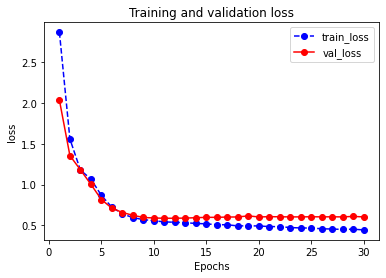

In [15]:
plot_metric(history, "loss")

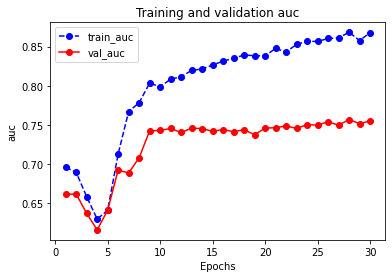

In [16]:
plot_metric(history, "auc")

我们再看一下模型在测试集上的效果

In [17]:
model.evaluate(x=x_test, y=y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4870 - auc: 0.7999


[0.4870416522026062, 0.7999452948570251]

### 五、使用模型

In [18]:
# 预测概率
model.predict(x_test[0:5])

array([[0.48573324],
       [0.53170854],
       [0.27932197],
       [0.79073834],
       [0.5181852 ]], dtype=float32)

In [19]:
# 预测分类
# model.predict_classes(x_test[0:5])
classes = np.argmax(model.predict(x_test[0:5]), axis=1)
classes

array([0, 0, 0, 0, 0])

### 六、保存模型

可以使用 `Keras` 方式保存模型，也可以使用 `TensorFlow` 原生方式保存。前者仅仅适合使用 `Python` 环境恢复模型，后者则可以跨平台进行模型部署。

推荐使用后一种方式进行保存。

#### 1. Keras方式保存

In [20]:
# 保存模型结构及权重
model.save('./data/keras_model.h5')

# 删除现有模型
del model

# 加载保存的模型
model = models.load_model('./data/keras_model.h5')
model.evaluate(x_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4870 - auc: 0.7999


[0.4870416522026062, 0.7999452948570251]

In [21]:
# 保存模型结构
json_str = model.to_json()

# 恢复模型结构
model_json = models.model_from_json(json_str)

In [22]:
# 保存模型权重
model.save_weights('./data/keras_model_weight.h5')

# 恢复模型结构
model_json = models.model_from_json(json_str)
model_json.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC"])

# 加载权重
model_json.load_weights('./data/keras_model_weight.h5')
model_json.evaluate(x_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4870 - auc: 0.7999


[0.4870416522026062, 0.7999452948570251]